# Lista de Exercícios 9

**Aluno**: Vítor Gabriel Reis Caitité

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from math import *
from scipy import stats
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, roc_curve, precision_recall_curve
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
import seaborn as sns
from lifelines import WeibullAFTFitter

## Leitura do Dataset



A base de dados selecionada para esse experimento foi a "Heart Failure Clinical Records" (coletado em: https://archive.ics.uci.edu/dataset/519/heart+failure+clinical+records). Este conjunto de dados contém os registros médicos de 299 pacientes com insuficiência cardíaca, coletados durante o período de acompanhamento, onde cada perfil de paciente possui 13 características clínicas.

*Features* clínicas:

- idade: idade do paciente (anos);
- anemia: diminuição de hemácias ou hemoglobina (booleano);
- creatinina fosfoquinase (CPK): nível da enzima CPK no sangue (mcg/L);
- diabetes: se o paciente tem diabetes (booleano);
- fração de ejeção: porcentagem de sangue que sai do coração a cada contração (porcentagem);
- pressão alta: se o paciente tem hipertensão (booleano);
- plaquetas: plaquetas no sangue (quiloplaquetas/mL);
- sexo: mulher ou homem (binário);
- creatinina sérica: nível de creatinina sérica no sangue (mg/dL);
- sódio sérico: nível de sódio sérico no sangue (mEq/L);
- tabagismo: se o paciente fuma ou não (booleano);
- tempo: período de acompanhamento (dias);
- evento de morte: se o paciente morreu durante o período de acompanhamento (booleano).


In [2]:
dataset = pd.read_csv('~/Documents/UFMG/Doutorado/materias/parametric-and-nonparametric-regression-models/exercise_9/heart_failure_clinical_records_dataset.csv', header=0, sep=",", engine='python')
dataset.head(5)
dataset

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
294,62.0,0,61,1,38,1,155000.00,1.1,143,1,1,270,0
295,55.0,0,1820,0,38,0,270000.00,1.2,139,0,0,271,0
296,45.0,0,2060,1,60,0,742000.00,0.8,138,0,0,278,0
297,45.0,0,2413,0,38,0,140000.00,1.4,140,1,1,280,0


## Análise Exploratória

### Matriz de Correlação




A matriz abaixo exibe a correlação entre as variáveis do conjunto de dados.

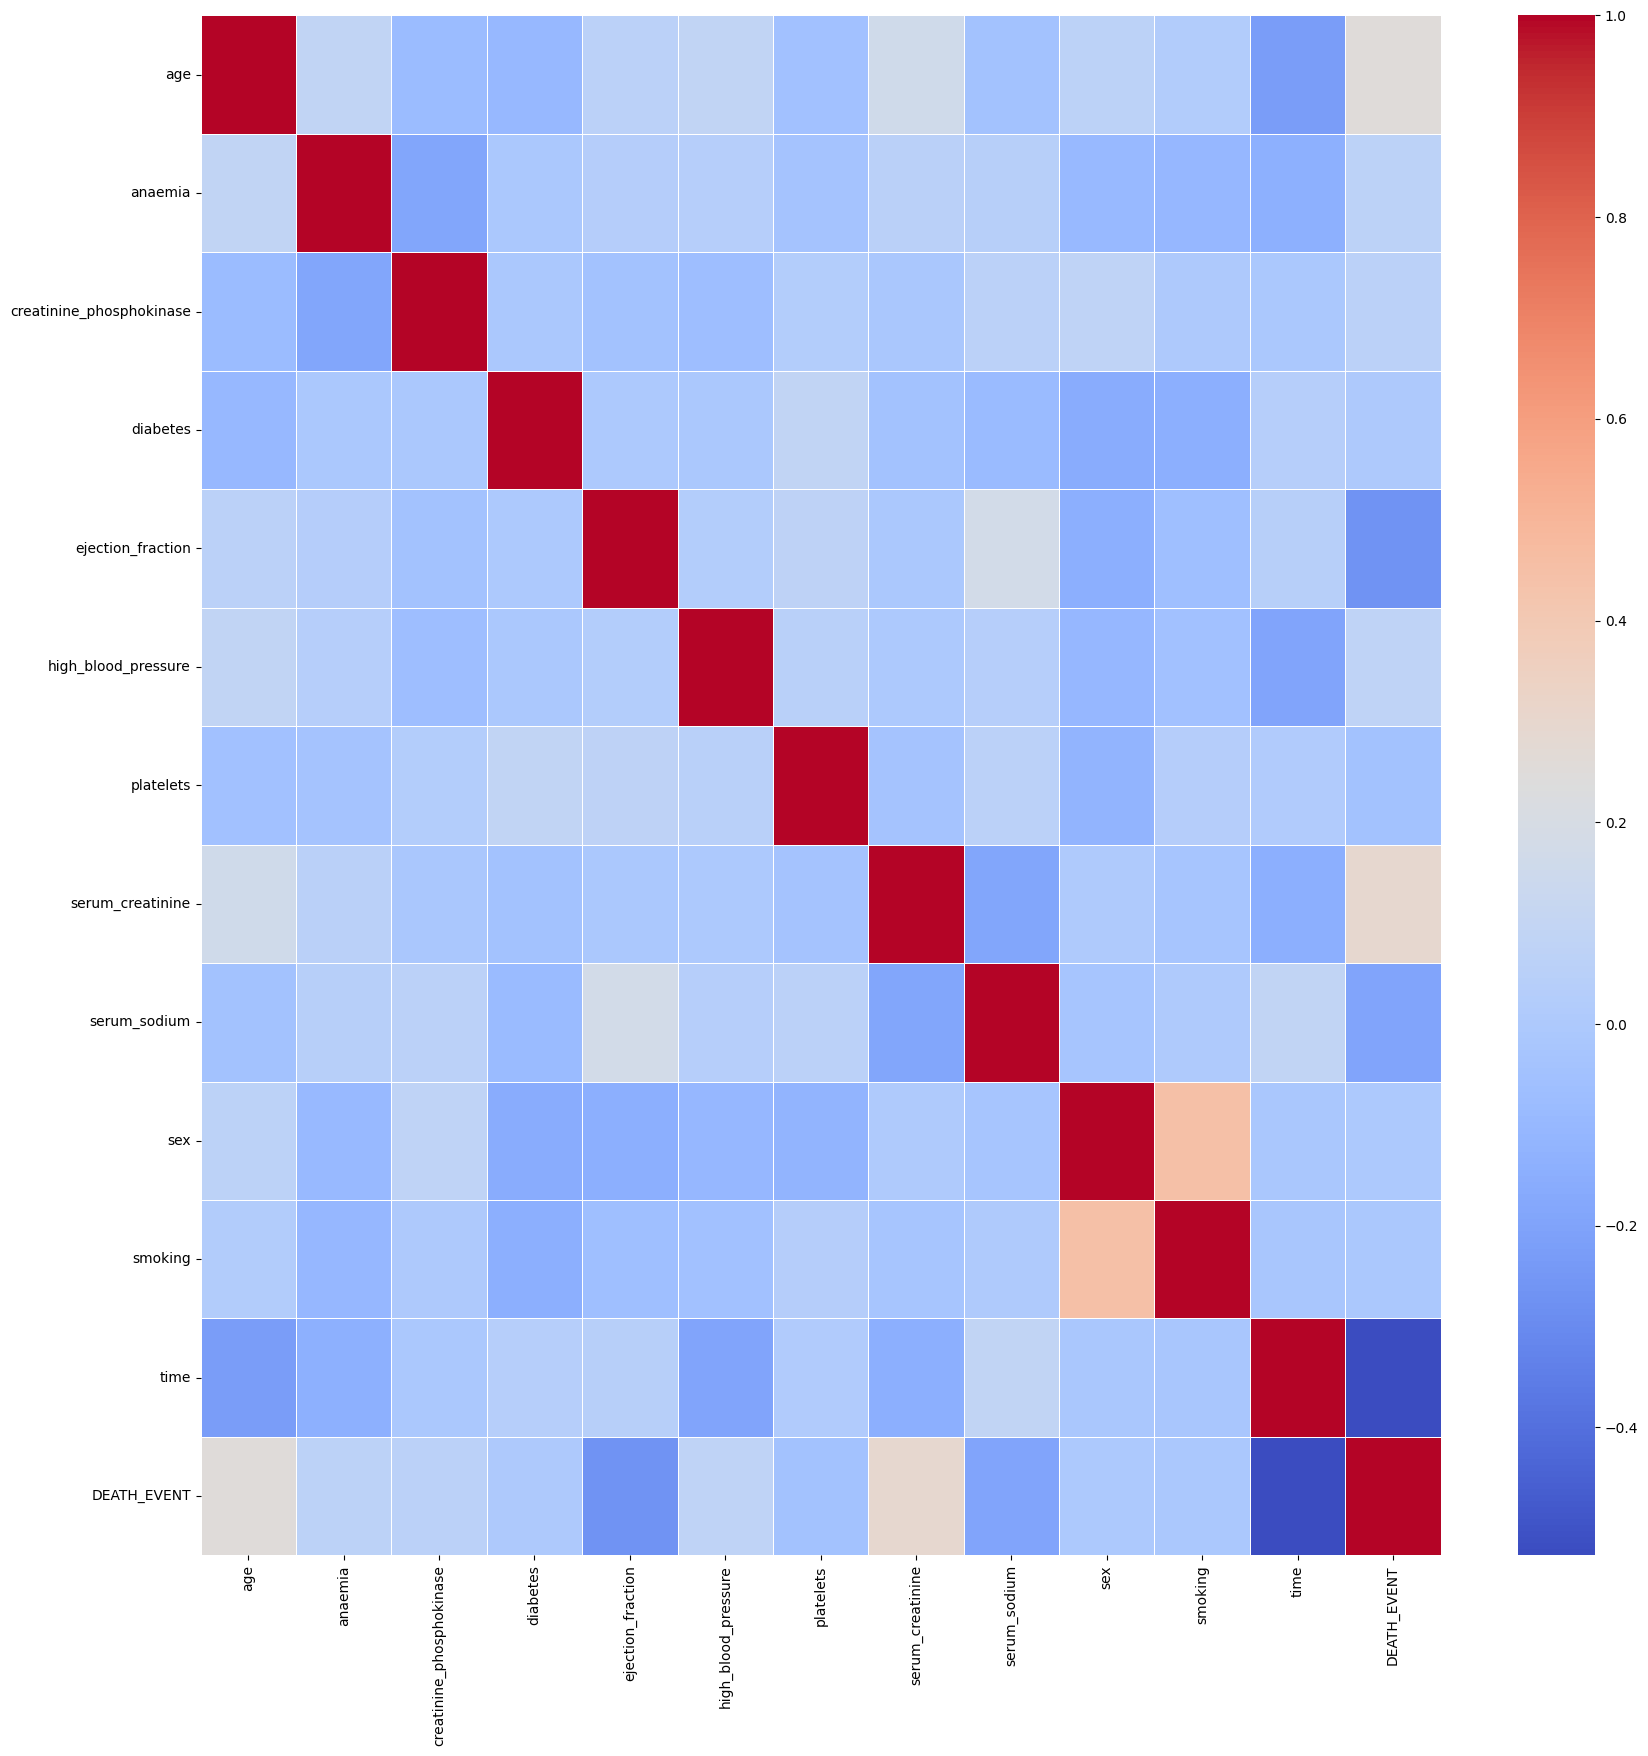

In [3]:
correlation_matrix = dataset.corr()

# Mapa de calor da correlação
plt.figure(figsize=(20, 20))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.show()

### Distribuição Etária

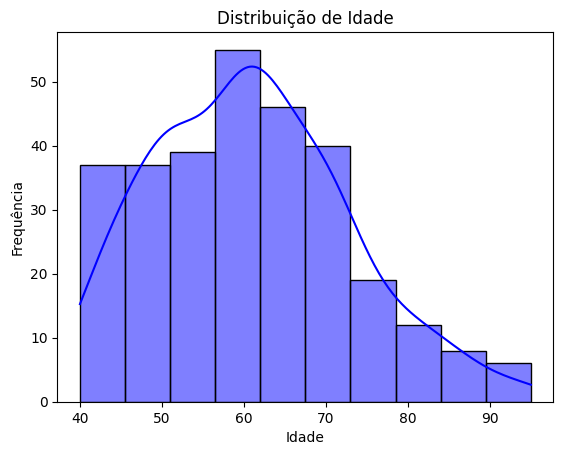

In [4]:
sns.histplot(dataset['age'], bins=10, kde=True, color='blue')
plt.title("Distribuição de Idade")
plt.xlabel("Idade")
plt.ylabel("Frequência")
plt.show()

## Creatinina Sérica vs Óbito

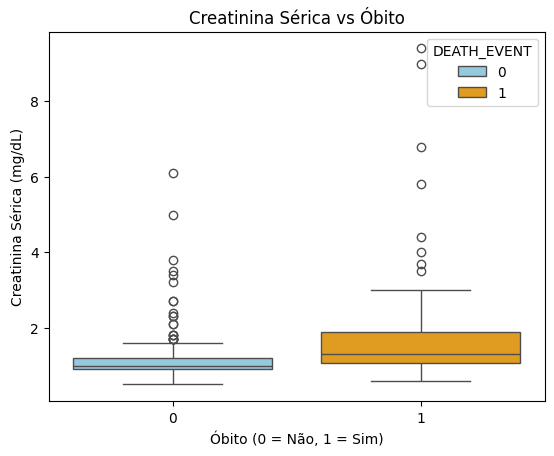

In [5]:
sns.boxplot(x='DEATH_EVENT', y='serum_creatinine', data=dataset, hue='DEATH_EVENT', dodge=False, palette={0: 'skyblue', 1: 'orange'})
plt.title("Creatinina Sérica vs Óbito")
plt.xlabel("Óbito (0 = Não, 1 = Sim)")
plt.ylabel("Creatinina Sérica (mg/dL)")
plt.show()

## Sódio sérico vs Óbito 

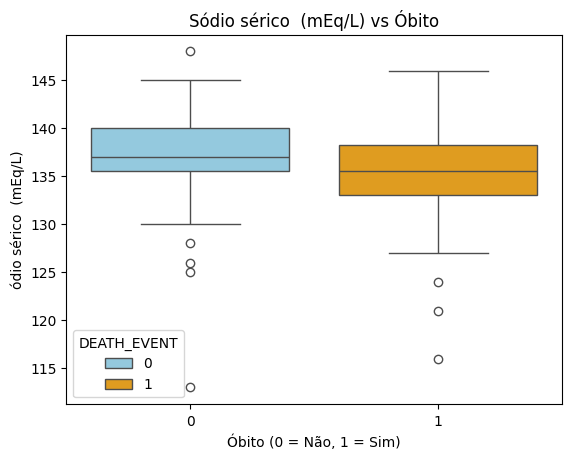

In [6]:
sns.boxplot(x='DEATH_EVENT', y='serum_sodium', data=dataset,  hue='DEATH_EVENT', dodge=False, palette={0: 'skyblue', 1: 'orange'})
plt.title("Sódio sérico  (mEq/L) vs Óbito")
plt.xlabel("Óbito (0 = Não, 1 = Sim)")
plt.ylabel("ódio sérico  (mEq/L)")
plt.show()

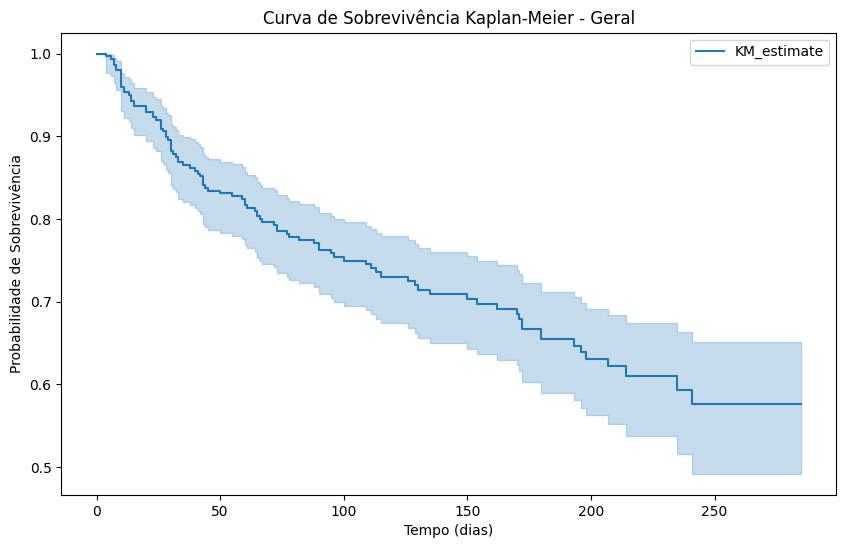

In [7]:
# Estimador Kaplan-Meier
kmf = KaplanMeierFitter()

# Curva de sobrevivência geral
plt.figure(figsize=(10, 6))
kmf.fit(durations=dataset['time'], event_observed=dataset['DEATH_EVENT'])
kmf.plot_survival_function()
plt.title("Curva de Sobrevivência Kaplan-Meier - Geral")
plt.xlabel("Tempo (dias)")
plt.ylabel("Probabilidade de Sobrevivência")
plt.show()

A curva de Kaplan-Meier geral é uma representação do tempo de sobrevivência de todos os indivíduos no estudo, sem considerar grupos específicos.

- Os dados são divididos nos tempos de falha observados (quando o evento ocorre). Se houver censura, esses indivíduos são considerados no cálculo até o ponto em que foram observados. Para cada tempo de falha, a probabilidade de sobrevivência é calculada considerando o número de eventos que ocorreram até aquele ponto e o número de indivíduos que estavam em risco de falha naquele momento.

- A curva de Kaplan-Meier mostra a probabilidade de um indivíduo "sobreviver" (ou não experimentar o evento) até um determinado tempo. Ela começa em 100% de sobrevivência (no início do estudo) e diminui conforme os eventos (nesse caso, mortes) ocorrem. Se houver censura, o gráfico se "plana" no ponto da censura, indicando que a observação foi interrompida.

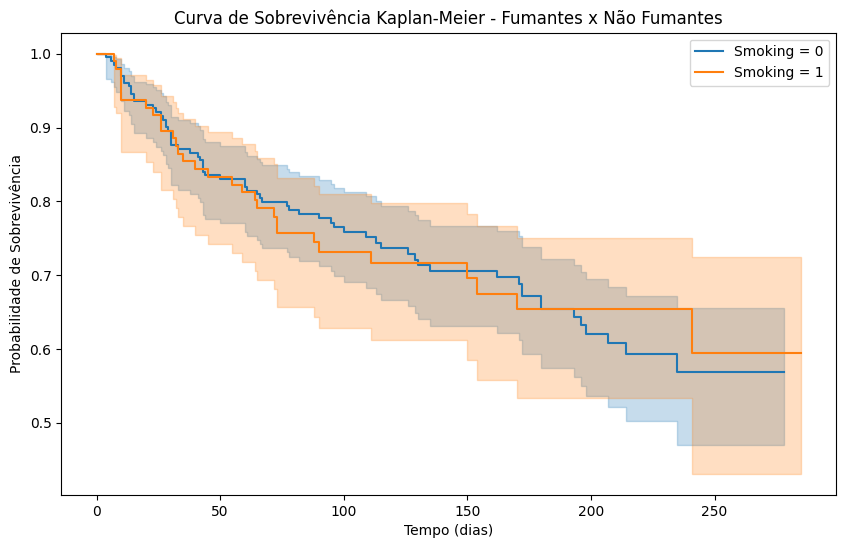

In [8]:
# Comparação por grupos - Fumantes x Não Fumantes
groups = dataset['smoking']
plt.figure(figsize=(10, 6))

for group in groups.unique():
    mask = groups == group
    kmf.fit(durations=dataset['time'][mask], event_observed=dataset['DEATH_EVENT'][mask], label=f"Smoking = {group}")
    kmf.plot_survival_function()

plt.title("Curva de Sobrevivência Kaplan-Meier - Fumantes x Não Fumantes")
plt.xlabel("Tempo (dias)")
plt.ylabel("Probabilidade de Sobrevivência")
plt.legend()
plt.show()

Cada curva de Kaplan-Meier por grupo mostra como as probabilidades de sobrevivência variam ao longo do tempo para os diferentes grupos.
Se as curvas de dois grupos (por exemplo, fumantes vs. não fumantes) se sobrepuserem, isso sugere que não há diferença significativa entre os grupos. Se as curvas se separarem de forma clara, isso sugere uma diferença na taxa de sobrevivência entre os grupos.

Nesse caso, não foi possível observar uma diferença significativa de forma clara.

### Teste log-rank

In [9]:
# Teste log-rank
results = logrank_test(
    dataset['time'][dataset['smoking'] == 1],
    dataset['time'][dataset['smoking'] == 0],
    event_observed_A=dataset['DEATH_EVENT'][dataset['smoking'] == 1],
    event_observed_B=dataset['DEATH_EVENT'][dataset['smoking'] == 0],
)
print(f"p-valor do teste log-rank para fumantes vs não fumantes: {results.p_value}")

p-valor do teste log-rank para fumantes vs não fumantes: 0.9639596778572351


O teste log-rank é usado para comparar as curvas de sobrevivência entre dois ou mais grupos (neste caso, fumantes e não fumantes). A hipótese nula é que as curvas de sobrevivência dos dois grupos são iguais. Um p-valor de 0,96 para o teste log-rank indica que não há evidência estatística suficiente para rejeitar a hipótese nula. Assim, isso sugere que não há diferença significativa nas taxas de sobrevivência entre os grupos de fumantes e não fumantes.

## Modelo de Regressão de Weibull

In [10]:
# Modelo de Weibull
aft = WeibullAFTFitter()
aft.fit(dataset, duration_col='time', event_col='DEATH_EVENT')
aft.print_summary()

<lifelines.WeibullAFTFitter: fitted with 299 total observations, 203 right-censored observations>
             duration col = 'time'
                event col = 'DEATH_EVENT'
   number of observations = 299
number of events observed = 96
           log-likelihood = -628.12
         time fit was run = 2025-01-19 22:53:15 UTC

---
                                  coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
param   covariate                                                                                                                 
lambda_ age                      -0.05      0.95      0.01           -0.07           -0.03                0.93                0.97
        anaemia                  -0.50      0.61      0.22           -0.94           -0.06                0.39                0.94
        creatinine_phosphokinase -0.00      1.00      0.00           -0.00           -0.00                1.00                1.00
        diabetes                 -0.15      0.86      0.23           -0.60            0.31                0.55                1.36
        ejection_fraction         0.05      1.05      0.01            0.03            0.08                1.03                1.08
        high_blood_pressure      -0.51      0.60      0.22           -0.95           -0.08                0.39                0.92
        platelets                 0.00      1.00      0.00           -0.00            0.00                1.00                1.00
        serum_creatinine         -0.33      0.72      0.07           -0.48           -0.19                0.62                0.83
        serum_sodium              0.04      1.05      0.02           -0.00            0.09                1.00                1.10
        sex                       0.25      1.28      0.26           -0.27            0.76                0.76                2.14
        smoking                  -0.12      0.89      0.26           -0.63            0.39                0.53                1.48
        Intercept                 1.99      7.33      3.29           -4.46            8.44                0.01             4644.58
rho_    Intercept                -0.04      0.96      0.09           -0.21            0.14                0.81                1.15

                                  cmp to     z      p  -log2(p)
param   covariate                                              
lambda_ age                         0.00 -4.96 <0.005     20.41
        anaemia                     0.00 -2.24   0.03      5.30
        creatinine_phosphokinase    0.00 -2.34   0.02      5.70
        diabetes                    0.00 -0.63   0.53      0.92
        ejection_fraction           0.00  4.53 <0.005     17.38
        high_blood_pressure         0.00 -2.31   0.02      5.59
        platelets                   0.00  0.47   0.64      0.64
        serum_creatinine            0.00 -4.56 <0.005     17.57
        serum_sodium                0.00  1.87   0.06      4.01
        sex                         0.00  0.93   0.35      1.51
        smoking                     0.00 -0.45   0.65      0.62
        Intercept                   0.00  0.61   0.54      0.88
rho_    Intercept                   0.00 -0.43   0.67      0.58
---
Concordance = 0.74
AIC = 1282.24
log-likelihood ratio test = 84.64 on 11 df
-log2(p) of ll-ratio test = 42.29

O coeficiente associado a cada variável prediz como essa variável acelera ou desacelera o tempo de sobrevivência. Isso significa que o coeficiente controla a taxa de crescimento do tempo de falha. Um valor positivo indica que o aumento de $X_i$​ acelera o tempo de falha, da mesma forma, uma valor negativo indica que o aumento de $X_i$​ desacelera o tempo de falha (aumenta a sobrevivência).



In [11]:
# Coeficientes das variáveis preditoras
print("Coeficientes do modelo:", aft.params_)

Coeficientes do modelo: param    covariate               
lambda_  age                        -4.979770e-02
         anaemia                    -4.998812e-01
         creatinine_phosphokinase   -2.433047e-04
         diabetes                   -1.465928e-01
         ejection_fraction           5.245430e-02
         high_blood_pressure        -5.144129e-01
         platelets                   5.511458e-07
         serum_creatinine           -3.331508e-01
         serum_sodium                4.499511e-02
         sex                         2.456910e-01
         smoking                    -1.186956e-01
         Intercept                   1.992318e+00
rho_     Intercept                  -3.796329e-02
dtype: float64


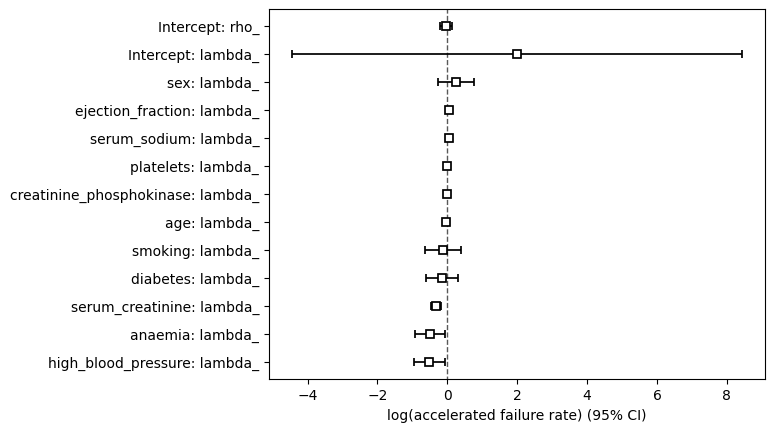

In [12]:
aft.plot()
plt.show()

## Distribuição dos Resíduos

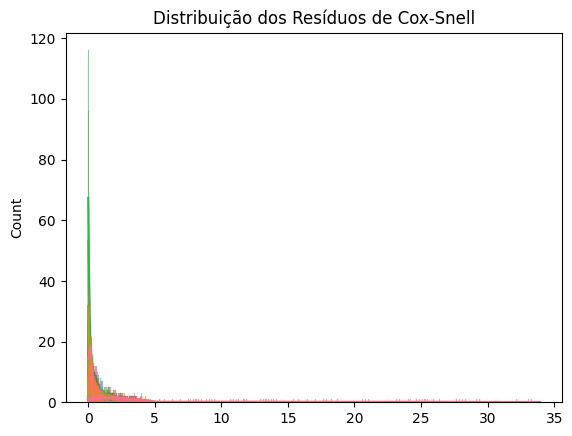

In [13]:
# Amostragem de uma fração dos dados (30% dos dados)
sampled_data = dataset.sample(frac=0.3, random_state=42)

# Cálculo dos resíduos na amostra
residuos = aft.predict_cumulative_hazard(sampled_data)
sns.histplot(residuos, kde=True, legend=False)
plt.title("Distribuição dos Resíduos de Cox-Snell")
plt.show()

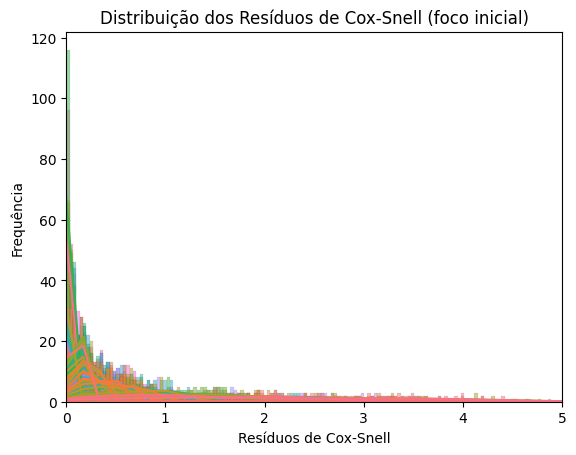

In [14]:
sns.histplot(residuos, kde=True, legend=False)
plt.title("Distribuição dos Resíduos de Cox-Snell (foco inicial)")
plt.xlabel("Resíduos de Cox-Snell")
plt.ylabel("Frequência")
plt.xlim(0, 5)  # Foco nas primeiras medidas do eixo X
plt.show()

As barras representam a contagem de valores dos resíduos de Cox-Snell em diferentes intervalos. Esses resíduos foram gerados a partir do modelo ajustado e refletem a discrepância entre os tempos observados e os tempos previstos. Sob um modelo bem ajustado, os resíduos devem seguir aproximadamente uma distribuição exponencial Exp(1).
